# Algorithms for Big Data - Exercise 5
This lecture is focused in more advanced example of the CNN - Variational Autoencoder (VAE). 

We will use the MNIST dataset but other may be used as well.


[Open in Google colab](https://colab.research.google.com/github/rasvob/2020-21-ARD/blob/master/abd_05.ipynb)
[Download from Github](https://github.com/rasvob/2020-21-ARD/blob/master/abd_05.ipynb)

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt # plotting
import matplotlib.image as mpimg # images
import numpy as np #numpy
import tensorflow.compat.v2 as tf #use tensorflow v2 as a main 
import tensorflow.keras as keras # required for high level applications
from sklearn.model_selection import train_test_split # split for validation sets
from sklearn.preprocessing import normalize # normalization of the matrix
from scipy.signal import convolve2d # convolutionof the 2D signals
import scipy

tf.version.VERSION

'2.3.0'

In [ ]:
tf.compat.v1.disable_eager_execution()

In [ ]:
def show_history(history):
    plt.figure()
    for key in history.history.keys():
        plt.plot(history.epoch, history.history[key], label=key)
    plt.legend()
    plt.tight_layout()

def show_example(train_x, train_y, class_names):
    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(train_x[i].reshape(28,28), cmap=plt.cm.binary)
        plt.xlabel(class_names[train_y[i]])
    plt.show()

In [ ]:
class Mish(keras.layers.Activation):
    '''
    Mish Activation Function.
    .. math::
        mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + e^{x}))
    Shape:
        - Input: Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
        - Output: Same shape as the input.
    Examples:
        >>> X = Activation('Mish', name="conv1_act")(X_input)
    '''

    def __init__(self, activation, **kwargs):
        super(Mish, self).__init__(activation, **kwargs)
        self.__name__ = 'Mish'


def mish(inputs):
    return inputs * tf.math.tanh(tf.math.softplus(inputs))

keras.utils.get_custom_objects().update({'mish': Mish(mish)})

# We will use MNIST dataset in this example as in the previous ones

In [ ]:
# mnist is the basic dataset for image classifaction
dataset = tf.keras.datasets.mnist

# data from any dataset are loaded using the load_Data function
(train_x, train_y), (test_x, test_y) = dataset.load_data()

train_x = train_x.reshape(*train_x.shape, 1)
test_x = test_x.reshape(*test_x.shape, 1)

train_x = train_x/255.0
test_x = test_x/255.0

train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

# the data are in the form of 28x28 pixes with values 0-255.
print('Train data shape: ', train_x.shape, train_y.shape)
print('Validation data shape: ', valid_x.shape, valid_y.shape)
print('Test data shape:  ', test_x.shape, test_y.shape)

class_names = [str(x) for x in range(10)]
class_count = len(class_names)
print('Class count:', class_count, class_names)


11493376/11490434 [==============================] - 0s 0us/step
Train data shape:  (48000, 28, 28, 1) (48000,)
Validation data shape:  (12000, 28, 28, 1) (12000,)
Test data shape:   (10000, 28, 28, 1) (10000,)
Class count: 10 ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


#### Show example images of the dataset

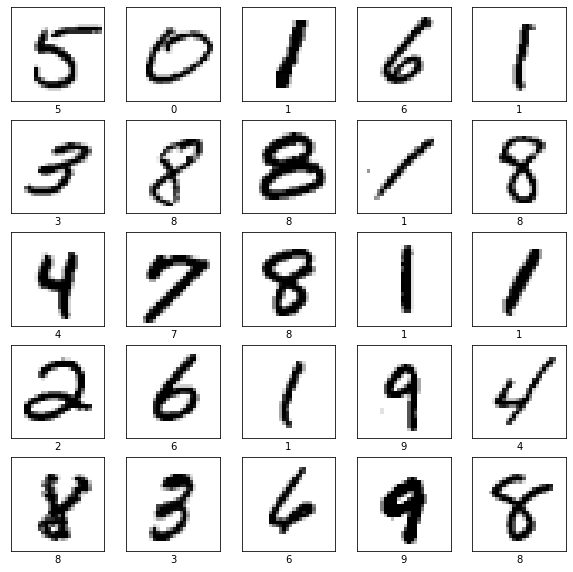

In [ ]:
show_example(train_x, train_y, class_names)

## We will reshape data from 28x28 to 32x32x1 shape
### We will again use subsampling/pooling in the model so we expect division of width and height by 2 with each of the subsampling step
### Dividing 28 by 2 multiple times will lead to sequence -> 28 >> 14 >> 7 >> ... Number 7 could be an issue for reconstruction because the subsampling uses integer division (7 / 2 = 3) but 2*3 = 6
### Resizing to 32x32 will save us from this issue because we will get sequence 32 >> 16 >> 8 >> 4 >> 2 >> 1 which is no problem to reconstruct

In [ ]:
import cv2
size = 32

train_x_res = np.array([cv2.resize(x, (size, size)) for x in train_x])
test_x_res = np.array([cv2.resize(x, (size, size)) for x in test_x])
valid_x_res = np.array([cv2.resize(x, (size, size)) for x in valid_x])

train_x_r = train_x_res.reshape(-1, size, size, 1).astype('float32')
test_x_r = test_x_res.reshape(-1, size, size, 1).astype('float32')
valid_x_r = valid_x_res.reshape(-1, size, size, 1).astype('float32')

In [ ]:
train_x_r.shape

(48000, 32, 32, 1)

In [ ]:
input_shape = train_x_r.shape[1:]
input_shape

(32, 32, 1)

# First we need to build an encoder

## Latent dimension define frow how many distribution we want to sample, each distribution a is Gaussian one, so we are creating basically multivariate Gaussian distribution

In [ ]:
latent_dim = 2

### The last two Dense layers represent vectors of mean and logarithm of variance of the individual distributions
#### Sampling function will combine these vectors with samples from Normal (Gaussian) distribution ~ N(0, 1)

In [ ]:
def sampling(args):
  mean_mu, log_var = args
  epsilon = keras.backend.random_normal(shape=keras.backend.shape(mean_mu), mean=0., stddev=1.)
  return mean_mu + keras.backend.exp(log_var/2)*epsilon

# It's worth to mention that we use strides=2 in the Conv2D layers instead of strides=1 so we are doing subsampling, beside the filtering, in this layers

In [ ]:
encoder_input = keras.layers.Input(shape=input_shape)
x = keras.layers.Conv2D(28, (3,3), strides=2, padding='same', activation='relu')(encoder_input)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(64, (3,3), strides=2, padding='same', activation='relu')(x)
x = keras.layers.BatchNormalization()(x)

before_flatten_shape = keras.backend.int_shape(x)[1:]
print(before_flatten_shape)

x = keras.layers.Flatten()(x)
mean_mu = keras.layers.Dense(latent_dim, name='mean_mu')(x)
log_var = keras.layers.Dense(latent_dim, name='log_var')(x)
encoder_output = keras.layers.Lambda(sampling)([mean_mu, log_var])

enc_model = keras.Model(encoder_input, encoder_output)
enc_model.summary()

(8, 8, 64)
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 28)   280         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 28)   112         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 8, 8, 64)     16192       batch_normalization[0][0]        
____________________________________________________________________________

# Now we need to define the decoder part
## Input shape is equal to the latent dimensions count

### We use Conv2DTranspose, sometimes called de-conv layer
A simple way to think about it is that it both performs the upsample operation and interprets the coarse input data to fill in the detail while it is upsampling. It is like a layer that combines the UpSampling2D and Conv2D layers into one layer. Models that use these layers can be referred to as deconvolutional networks, or deconvnets.

A deconvnet can be thought of as a convnet model that uses the same components (filtering, pooling) but in reverse, so instead of mapping pixels to features does the opposite.

# strides=2 in the Conv2DTranspose is responsible for the upsampling operation
### The Reshape layers creates from the vector of 64 elements matrix 8x8 which can be upsampled to the original size

In [ ]:
decoder_input = keras.layers.Input(shape = (latent_dim,) , name = 'decoder_input')
x = keras.layers.Dense(np.prod(before_flatten_shape))(decoder_input)
x = keras.layers.Reshape(before_flatten_shape)(x)
x = keras.layers.Conv2DTranspose(128, (3,3), strides=2, padding='same', activation='relu')(x)
x = keras.layers.Conv2DTranspose(1, (3,3), strides=2, padding='same', activation='sigmoid')(x)
decoder_output = x

dec_model = keras.Model(decoder_input, decoder_output)
dec_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 4096)              12288     
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 1)         1153      
Total params: 87,297
Trainable params: 87,297
Non-trainable params: 0
_________________________________________________________________


# Now we will just connect the two parts together

In [ ]:
vae_input = encoder_input

vae_output = dec_model(encoder_output)

vae_model = keras.Model(vae_input, vae_output)

# VAE uses specific loss function which we have to define ourselves
## The loss function combines RMSE with KL-divergence - KL divergence score, quantifies how much one probability distribution differs from another probability distribution. For more info see [this](https://machinelearningmastery.com/divergence-between-probability-distributions/) or [this](https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-understanding-kl-divergence-2b382ca2b2a8)

### We use the KL-divergence score to penalize the activation values of the mean and log_variance layers if they differ from N(0, 1) distribution - we want to be as close as possible to this distribution

In [ ]:
def total_loss_closure(mean_mu, log_var):
    def r_loss(y_true, y_pred):
      return keras.backend.mean(keras.backend.square(y_true - y_pred), axis=[0, 1])

    def kl_loss(y_true, y_pred):
      kl_loss =  -0.5 * keras.backend.sum(1 + log_var - keras.backend.square(mean_mu) - keras.backend.exp(log_var), axis = 1)
      return kl_loss

    def loss(y_true, y_pred):
      LOSS_FACTOR = 10000
      return LOSS_FACTOR*r_loss(y_true, y_pred) + kl_loss(y_true, y_pred)

    return loss

In [ ]:
vae_model.compile(optimizer='adam', loss = total_loss_closure(mean_mu, log_var))
es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, restore_best_weights=True)

batch_size = 128
epochs = 10
history = vae_model.fit(train_x_r, train_x_r, validation_data=(valid_x_r, valid_x_r), callbacks=[es], epochs=epochs, batch_size=batch_size)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
47616/48000 [============================>.] - ETA: 0s - loss: 554.1265WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
48000/48000 [==============================] - 4s 82us/sample - loss: 553.1989 - val_loss: 672.4659
Epoch 2/10
48000/48000 [==============================] - 4s 78us/sample - loss: 433.8967 - val_loss: 431.3703
Epoch 3/10
48000/48000 [==============================] - 4s 79us/sample - loss: 415.6289 - val_loss: 410.4465
Epoch 4/10
48000/48000 [==============================] - 4s 79us/sample - loss: 402.8562 - val_loss: 399.5229
Epoch 5/10
48000/48000 [==============================] - 4s 81us/sample - loss: 

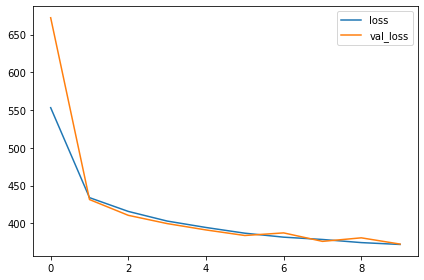

In [ ]:
show_history(history)

# Now we will try to reconstruct some images as in case of classic autoencoder

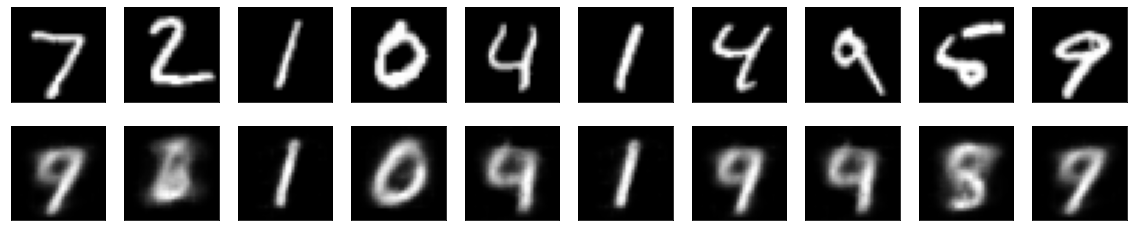

In [ ]:
predicted = vae_model.predict(test_x_r)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(test_x_r[i].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1+n)
    plt.imshow(predicted[i].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## If we use just the decoder part of the model and feed it samples from distribution N(0, 1) we can generate new images with the model

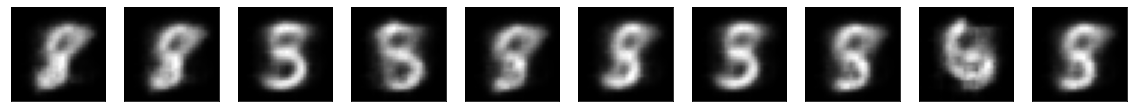

In [ ]:
n = 10
reconst_images = dec_model.predict(np.random.normal(0,1,size=(n,latent_dim)))

plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(reconst_images[i].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  

# We can display even the whole manifold
## How can we select scale?
### 3-sigma rule
 - 𝑃(𝜇 − 𝑘𝜎 < 𝑋 < 𝜇 + 𝑘𝜎) = 0.954 for k=2
 - k = 2, 𝜇 = 0, 𝜎 = 1 in our case so 95,4% of numbers will be in interval <-2, 2>

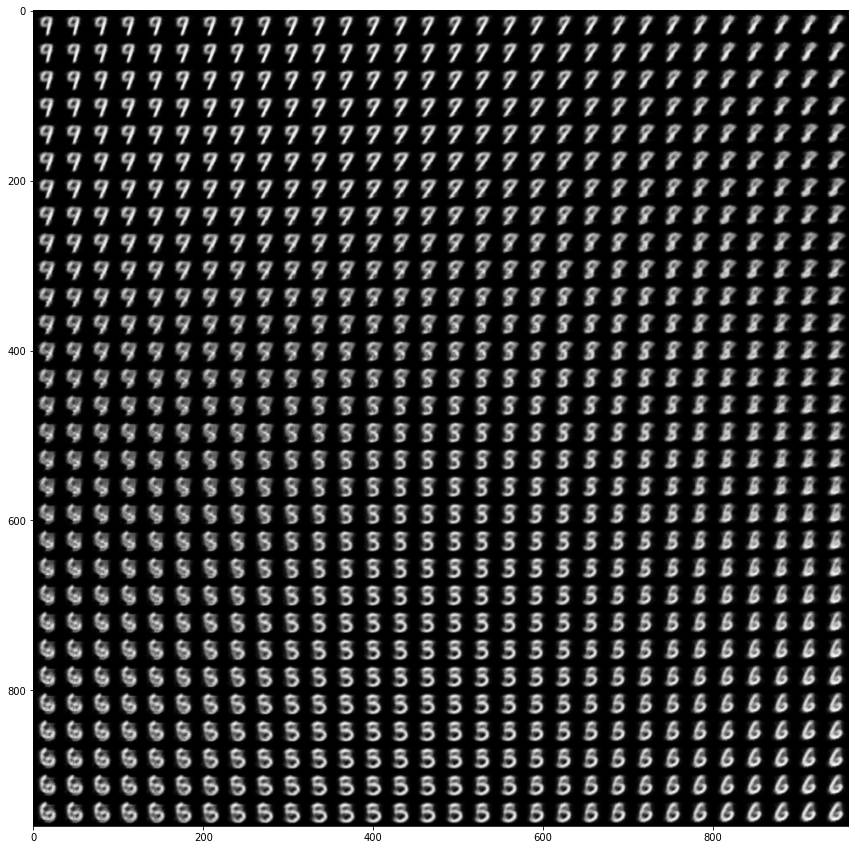

In [ ]:
def plot_latent(decoder):
    # display a n*n 2D manifold of digits
    n = 30
    digit_size = 32
    scale = 2.0
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
#     plt.xticks(pixel_range, sample_range_x)
#     plt.yticks(pixel_range, sample_range_y)
#     plt.xlabel("z[0]")
#     plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

plot_latent(dec_model)

# Task for the lecture
- Create another VAE model which will work with human faces
- We will use dataset Labeled Faces in the Wild [see this](https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html#sphx-glr-auto-examples-applications-plot-face-recognition-py)
- You can use same model architecture as in the lecture model for MNIST, just the input shape differes
- Train models with 2 and 200 latent dimensions vectors
- Reconstruct faces and generate some new
- Can you see any difference in images reconstructed/generated with latent vectors with 2 or 200 dimensions?
    - Write down your opinion to the bottom of the notebook!
        
## Beware that faces are more complex than MNIST digits
## Output is very similar to blurry images at the link above
## The output will be blurry as hell and usually only remotely remind you of original face
 - Generated faces are kinda scary so they would make great avatars for 3D shooters from the early 90s  :-)

In [ ]:
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split

In [ ]:
lfw_people = fetch_lfw_people(min_faces_per_person=10)

# Original shape is 64*47 

In [ ]:
lfw_people.images.shape

(4324, 62, 47)

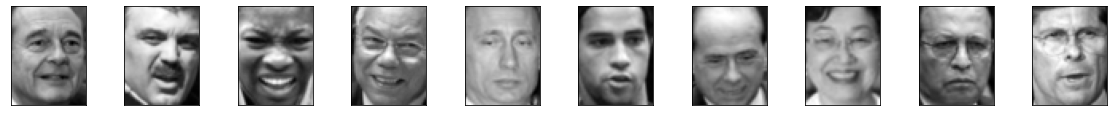

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(lfw_people.images[i].reshape(62, 47))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [ ]:
lfw_people = lfw_people.images.reshape(-1, 62, 47, 1)

In [ ]:
X_train, X_test = train_test_split(lfw_people, test_size=0.1, random_state=13)

In [ ]:
X_train.shape

(3891, 62, 47, 1)

In [ ]:
X_test.shape

(433, 62, 47, 1)

In [ ]:
import cv2
size = 64

train_x_res = np.array([cv2.resize(x, (size, size)) for x in X_train])
test_x_res = np.array([cv2.resize(x, (size, size)) for x in X_test])
train_x_r = train_x_res.reshape(-1, size, size, 1).astype('float32')/255.0
test_x_r = test_x_res.reshape(-1, size, size, 1).astype('float32')/255.0

In [ ]:
input_shape = train_x_r.shape[1:]

In [ ]:
input_shape

(64, 64, 1)

# VAE with 2 dims, vae_model is your VAE model

In [ ]:
latent_dim = 2

In [ ]:
encoder_input = keras.layers.Input(shape=input_shape)
x = keras.layers.Conv2D(28, (3,3), strides=2, padding='same', activation='relu')(encoder_input)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(64, (3,3), strides=2, padding='same', activation='relu')(x)
x = keras.layers.BatchNormalization()(x)

before_flatten_shape = keras.backend.int_shape(x)[1:]
print(before_flatten_shape)

x = keras.layers.Flatten()(x)
mean_mu = keras.layers.Dense(latent_dim, name='mean_mu')(x)
log_var = keras.layers.Dense(latent_dim, name='log_var')(x)
encoder_output = keras.layers.Lambda(sampling)([mean_mu, log_var])

enc_model = keras.Model(encoder_input, encoder_output)
enc_model.summary()

(16, 16, 64)
Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 32, 32, 28)   280         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 32, 32, 28)   112         conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 16, 16, 64)   16192       batch_normalization_6[0][0]      
_________________________________________________________________________

In [ ]:
decoder_input = keras.layers.Input(shape = (latent_dim,) , name = 'decoder_input')
x = keras.layers.Dense(np.prod(before_flatten_shape))(decoder_input)
x = keras.layers.Reshape(before_flatten_shape)(x)
x = keras.layers.Conv2DTranspose(128, (3,3), strides=2, padding='same', activation='relu')(x)
x = keras.layers.Conv2DTranspose(1, (3,3), strides=2, padding='same', activation='sigmoid')(x)
decoder_output = x

dec_model = keras.Model(decoder_input, decoder_output)
dec_model.summary()

Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 16384)             49152     
_________________________________________________________________
reshape_3 (Reshape)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 64, 64, 1)         1153      
Total params: 124,161
Trainable params: 124,161
Non-trainable params: 0
_________________________________________________________________


In [ ]:
vae_input = encoder_input

vae_output = dec_model(encoder_output)

vae_model = keras.Model(vae_input, vae_output)

In [ ]:
vae_model.compile(optimizer='adam', loss = total_loss_closure(mean_mu, log_var))
es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, restore_best_weights=True)

batch_size = 128
epochs = 10
history = vae_model.fit(train_x_r, train_x_r, validation_split=0.1, callbacks=[es], epochs=epochs, batch_size=batch_size)

Train on 3501 samples, validate on 390 samples
Epoch 1/10
3501/3501 [==============================] - 1s 285us/sample - loss: 323.5804 - val_loss: 277.9391
Epoch 2/10
3501/3501 [==============================] - 1s 186us/sample - loss: 214.9015 - val_loss: 272.9970
Epoch 3/10
3501/3501 [==============================] - 1s 186us/sample - loss: 183.2595 - val_loss: 270.9260
Epoch 4/10
3501/3501 [==============================] - 1s 188us/sample - loss: 176.7152 - val_loss: 268.3754
Epoch 5/10
3501/3501 [==============================] - 1s 187us/sample - loss: 176.8224 - val_loss: 256.7068
Epoch 6/10
3501/3501 [==============================] - 1s 190us/sample - loss: 173.0690 - val_loss: 245.2695
Epoch 7/10
3501/3501 [==============================] - 1s 189us/sample - loss: 174.4252 - val_loss: 241.2008
Epoch 8/10
3501/3501 [==============================] - 1s 187us/sample - loss: 174.1890 - val_loss: 237.8051
Epoch 9/10
3501/3501 [==============================] - 1s 189us/sample -

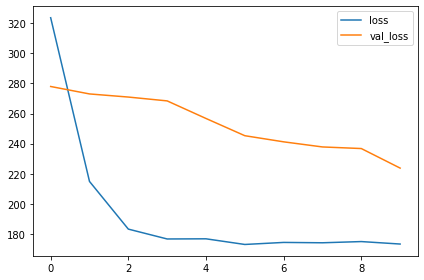

In [ ]:
show_history(history)

# VAE with 200 dims, vae_model is your VAE model

In [ ]:
latent_dim = 200

In [ ]:
encoder_input = keras.layers.Input(shape=input_shape)
x = keras.layers.Conv2D(28, (3,3), strides=2, padding='same', activation='relu')(encoder_input)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(64, (3,3), strides=2, padding='same', activation='relu')(x)
x = keras.layers.BatchNormalization()(x)

before_flatten_shape = keras.backend.int_shape(x)[1:]
print(before_flatten_shape)

x = keras.layers.Flatten()(x)
mean_mu = keras.layers.Dense(latent_dim, name='mean_mu')(x)
log_var = keras.layers.Dense(latent_dim, name='log_var')(x)
encoder_output = keras.layers.Lambda(sampling)([mean_mu, log_var])

enc_model = keras.Model(encoder_input, encoder_output)
enc_model.summary()

(16, 16, 64)
Model: "functional_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 32, 32, 28)   280         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 32, 32, 28)   112         conv2d_8[0][0]                   
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 16, 16, 64)   16192       batch_normalization_8[0][0]      
_________________________________________________________________________

In [ ]:
decoder_input = keras.layers.Input(shape = (latent_dim,) , name = 'decoder_input')
x = keras.layers.Dense(np.prod(before_flatten_shape))(decoder_input)
x = keras.layers.Reshape(before_flatten_shape)(x)
x = keras.layers.Conv2DTranspose(128, (3,3), strides=2, padding='same', activation='relu')(x)
x = keras.layers.Conv2DTranspose(1, (3,3), strides=2, padding='same', activation='sigmoid')(x)
decoder_output = x

dec_model = keras.Model(decoder_input, decoder_output)
dec_model.summary()

Model: "functional_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 200)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 16384)             3293184   
_________________________________________________________________
reshape_4 (Reshape)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 64, 64, 1)         1153      
Total params: 3,368,193
Trainable params: 3,368,193
Non-trainable params: 0
_________________________________________________________________


In [ ]:
vae_input = encoder_input

vae_output = dec_model(encoder_output)

vae_model = keras.Model(vae_input, vae_output)

In [ ]:
vae_model.compile(optimizer='adam', loss = total_loss_closure(mean_mu, log_var))
es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, restore_best_weights=True)

batch_size = 128
epochs = 10
history = vae_model.fit(train_x_r, train_x_r, validation_split=0.1, callbacks=[es], epochs=epochs, batch_size=batch_size)

Train on 3501 samples, validate on 390 samples
Epoch 1/10
3501/3501 [==============================] - 1s 330us/sample - loss: 1226.3272 - val_loss: 321.8176
Epoch 2/10
3501/3501 [==============================] - 1s 222us/sample - loss: 500.6933 - val_loss: 314.4115
Epoch 3/10
3501/3501 [==============================] - 1s 214us/sample - loss: 399.2910 - val_loss: 302.9740
Epoch 4/10
3501/3501 [==============================] - 1s 213us/sample - loss: 318.2727 - val_loss: 295.6272
Epoch 5/10
3501/3501 [==============================] - 1s 213us/sample - loss: 280.1773 - val_loss: 296.4742
Epoch 6/10
3501/3501 [==============================] - 1s 215us/sample - loss: 222.9680 - val_loss: 300.1429
Epoch 7/10
3501/3501 [==============================] - 1s 212us/sample - loss: 198.2797 - val_loss: 301.4273
Epoch 8/10
3501/3501 [==============================] - 1s 216us/sample - loss: 196.8197 - val_loss: 313.5879
Epoch 9/10
3501/3501 [==============================] - 1s 217us/sample 

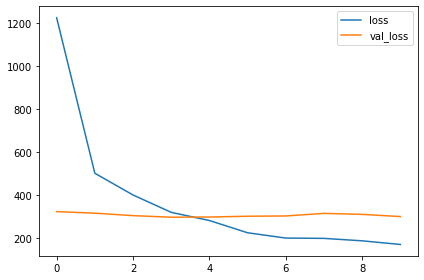

In [ ]:
show_history(history)

# You can vizualize models outputs with code below

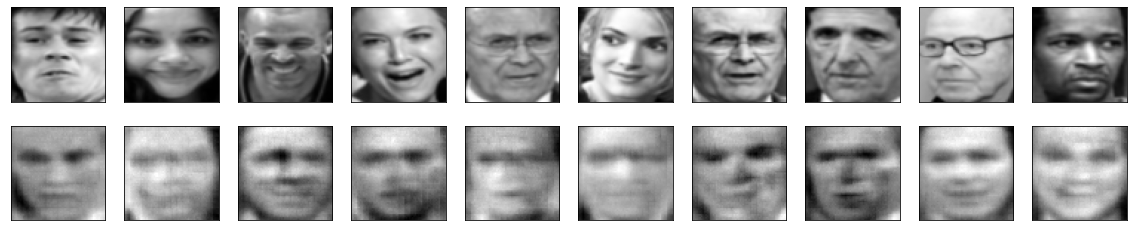

In [ ]:
predicted = vae_model.predict(test_x_r)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(test_x_r[i].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1+n)
    plt.imshow(predicted[i].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

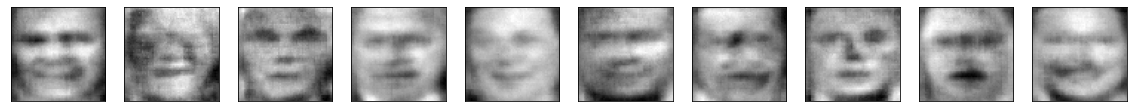

In [ ]:
n = 10
reconst_images = dec_model.predict(np.random.normal(0,1,size=(n,latent_dim)))

plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(reconst_images[i].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  

# Can you see any difference in images reconstructed/generated with latent vectors with 2 or 200 dimensions?

In [ ]:
# Write your opinion on the differences here!

In [ ]:
Ano, modely se velmi liší a čím větší je rozměr, tím větší je rozdíl, který podle mého názoru neuronová síť určí lépe.